# 1. Import libraries

In [109]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from functools import partial
from sklearn.ensemble import RandomForestRegressor

# 2. Import dataset and data exploration

In [110]:
data = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [111]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


🔍   Observation: There are both numerical values, categorical and binary features in this dataset.

In [112]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


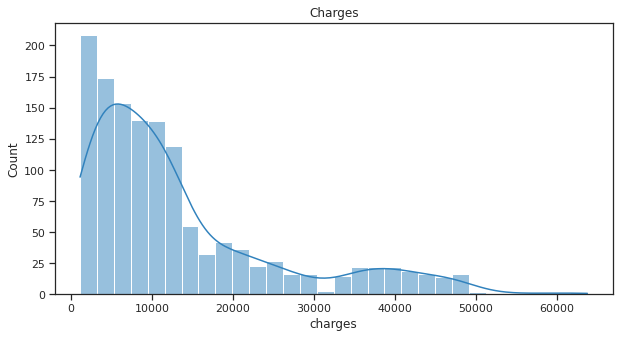

In [113]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data['charges'], kde=True, color='#3182bd')
plt.title('Charges')
plt.show()

🔍   Observation: Charges vary from 1121 to 63770, and with relatively low standard deviation. Furthermore, most of the charges are low and centred around 10000.

In [114]:
data.isnull().values.any()

False

🔍   Observation: There are no columns that have missing values, thus we don't need to decide on a method to insert replacement values or removing them all together.

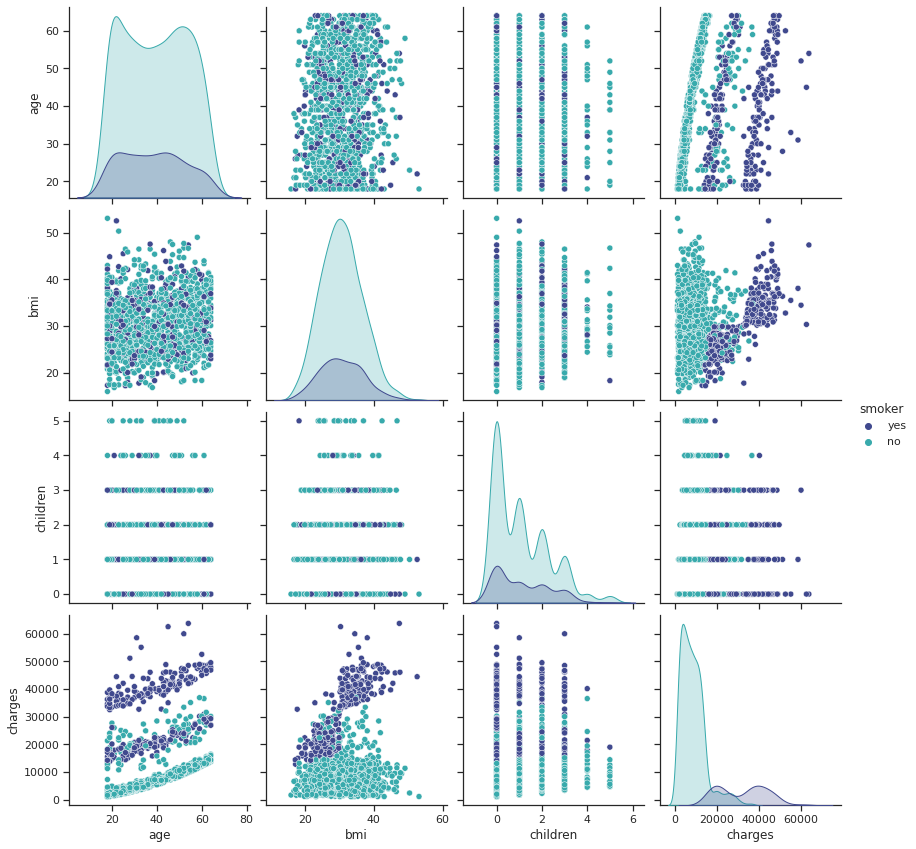

In [115]:
sns.pairplot(data, hue='smoker', palette='mako', height=3.0)
plt.show()

🔍   Observation: Whether the person is a smoker or not creates a visible seperation of samples in charges vs. age, as well as with charges vs. bmi. Generally, smokers seem to be associated with higher charges. Furthermore, the majority of the samples in this dataset seems to be non-smokers. This means that a future prediction model may be bias towards non-smokers.

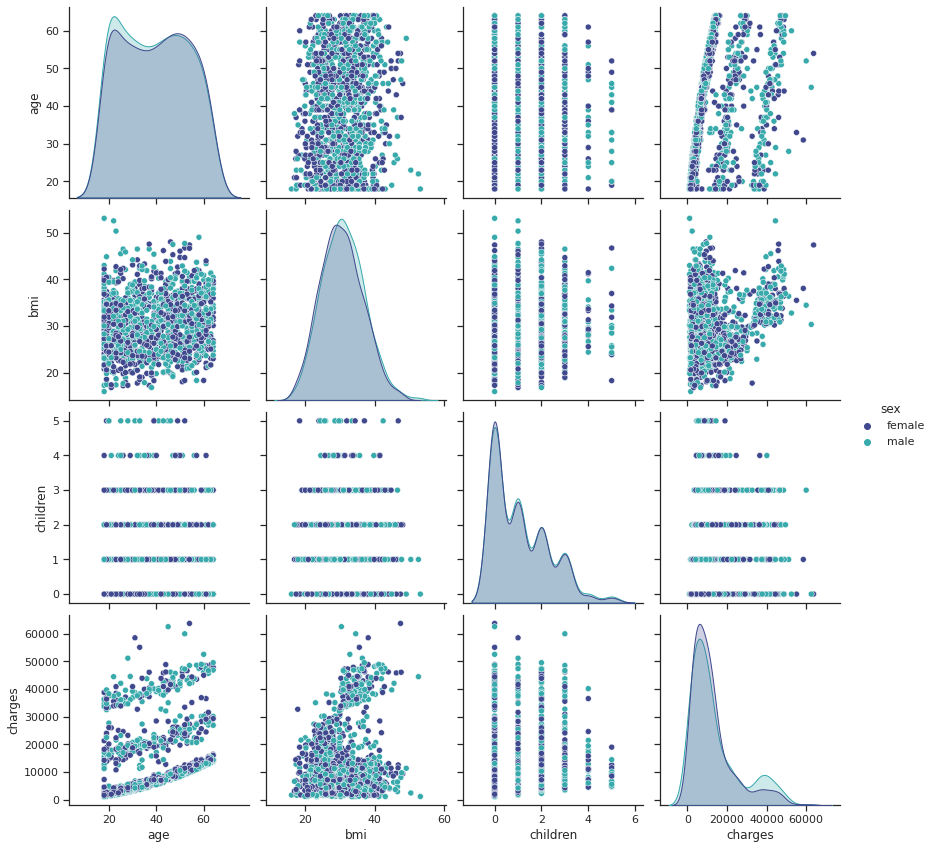

In [116]:
sns.pairplot(data, hue='sex', palette='mako', height=3.0)
plt.show()

🔍   Observation: There seems to be no differentiation between males and females.

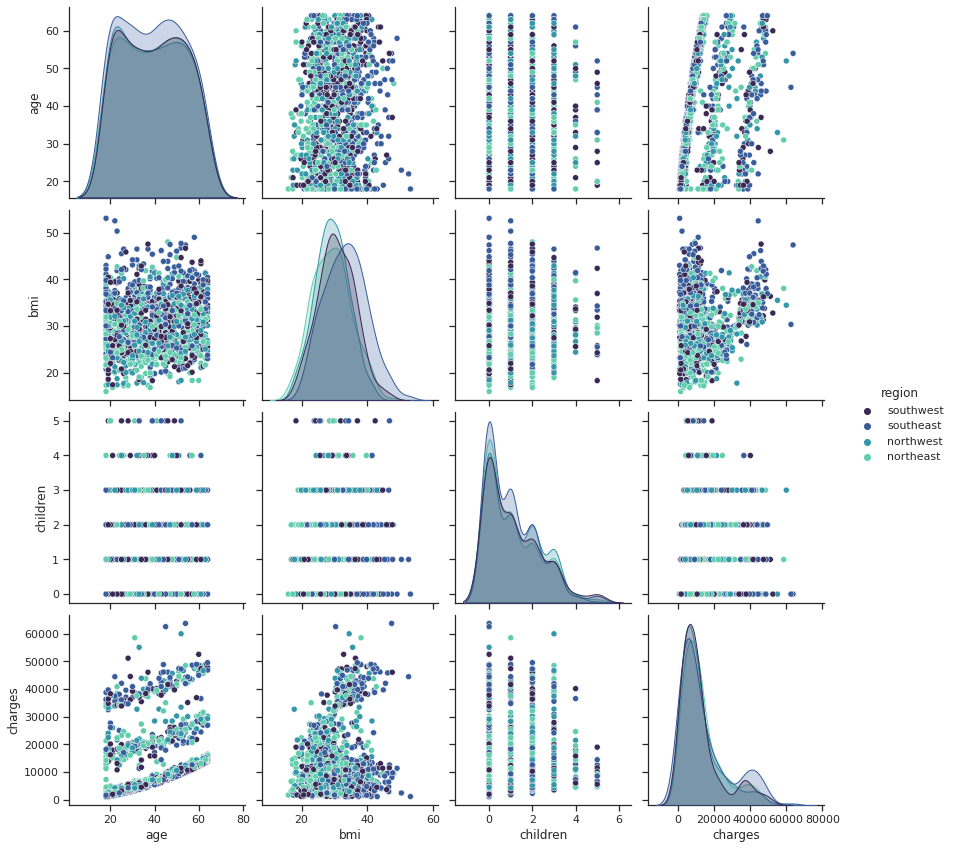

In [117]:
sns.pairplot(data, hue='region', palette='mako', height=3.0)
plt.show()

🔍   Observation: There seems to be no visible relationship between region and charges.

Finally, before creating the prediction models, lets create a dataframe to store our results for easy comparison later on.

In [118]:
def add_results(results_df, model_name, mae_valid, mae_test, mse_valid, mse_test):
  res = {'model_variant': model_name,
       'mae_valid': mae_valid,
       'mae_test': mae_test,
       'mse_valid': mse_valid, 
       'mse_test': mse_test}
  results_df = results_df.append(res, ignore_index=True)
  return results_df

In [119]:
prediction_results = pd.DataFrame(columns=['model_variant', 'mae_valid', 'mae_test', 'mse_valid', 'mse_test'])

# 3. Pre-Processing (Normalize and One-Hot-Encoding)

Before we design any sort of prediction model, we need to normalize numerical values and one-hot-encode categorical and binary features. This is not strictly neccesary for all of the models, but regardless, this is done now in order to have clear definition of what is considered training, validation and test sets.

In [120]:
# Create a custom "transformer" (ct)
ct = make_column_transformer(
    (MinMaxScaler(), ['age', 'bmi', 'children']),                           # features to normalize
    (OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region'])   # features to one hot encode
)

# Split dataset into x and y
x = data.drop(['charges'], axis=1)
y = data.charges

# Divide x and y into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Divide x_train and y_train into train and validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Fit custom transformer to features
ct.fit(x_train)

# Transform datasets that contains features
x_train_norm = ct.transform(x_train)
x_valid_norm = ct.transform(x_valid)
x_test_norm = ct.transform(x_test)

The dataset has 6 features, however, due to the one-hot-encoding there are now 11 features to input to the models later on.

# 4. Predicting charges using a linear regression model

As stated earler, whether a person is a smoker or not seems to have a significant impact on charges. This needs to be taken into consideration when designing the prediction model. Furthermore, the charges vs. bmi plot seems to differentiate smokers and non-smokers the best. Thus, this seems like a good starting point. Naturally, the linear prediction model is not going to have the best metrics when compared to more complex models, but to make the best of it we will make two different linear prediction models: one for smokers and one for non-smokers.

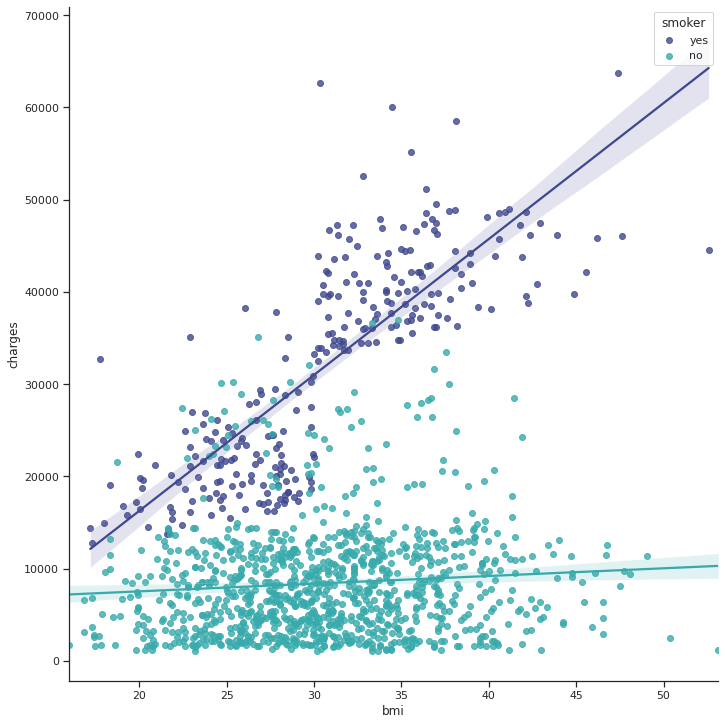

In [121]:
sns.lmplot(data=data, x='bmi', y='charges', palette='mako', hue='smoker', height=10, legend_out=False)

The two regression lines above essentially is the two models we're about to create.

But before we create the model, we need to slightly modify the training, validation and test data - since we only need the bmi, smoker and charges features for the linear models. Moreover, the normalized and one-hot-encoded data is not needed here, so we will use the non-pre-processed datasets.

In [122]:
# Isolate smoker and charges features based on if a person is a smoker or not
x_smoker_0 = np.array(data.loc[data['smoker'] == 'no'].bmi)
y_smoker_0 = np.array(data.loc[data['smoker'] == 'no'].charges)
x_smoker_1 = np.array(data.loc[data['smoker'] == 'yes'].bmi)
y_smoker_1 = np.array(data.loc[data['smoker'] == 'yes'].charges)

# Split new datasets into train and test
x_train_smoker_0, x_test_smoker_0, y_train_smoker_0, y_test_smoker_0 = train_test_split(x_smoker_0, y_smoker_0, test_size=0.2, random_state=42)
x_train_smoker_1, x_test_smoker_1, y_train_smoker_1, y_test_smoker_1 = train_test_split(x_smoker_1, y_smoker_1, test_size=0.2, random_state=42)

# Set correct shape
x_train_smoker_0 = x_train_smoker_0[:, None]
x_train_smoker_1 = x_train_smoker_1[:, None]
x_test_smoker_0 = x_test_smoker_0[:, None]
x_test_smoker_1 = x_test_smoker_1[:, None]

In [123]:
def create_and_predict_linear_model(x_train, y_train, x_test):
  model = LinearRegression()
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  return y_pred

In [124]:
# Calculate metrics for non-smokers
smoker_0_pred = create_and_predict_linear_model(
    x_train_smoker_0,
    y_train_smoker_0,
    x_test_smoker_0,
)
smoker_0_mae = mean_absolute_error(y_test_smoker_0, smoker_0_pred)
smoker_0_mse = mean_squared_error(y_test_smoker_0, smoker_0_pred)

# Calculate metrics for smokers
smoker_1_pred = create_and_predict_linear_model(
    x_train_smoker_1,
    y_train_smoker_1,
    x_test_smoker_1,
)
smoker_1_mae = mean_absolute_error(y_test_smoker_1, smoker_1_pred)
smoker_1_mse = mean_squared_error(y_test_smoker_1, smoker_1_pred)

# Calculate overall metrics
smoker_all_pred = np.concatenate((smoker_0_pred, smoker_1_pred), axis=0)
y_smoker_all = np.concatenate((y_test_smoker_0, y_test_smoker_1), axis=0)
smoker_all_mae = mean_absolute_error(y_smoker_all, smoker_all_pred)
smoker_all_mse = mean_squared_error(y_smoker_all, smoker_all_pred)

In [125]:
linear_model_results = pd.DataFrame({
    'Non-smokers': [smoker_0_mae, smoker_0_mse],
    'Smokers': [smoker_1_mae, smoker_1_mse],
    'Overall': [smoker_all_mae, smoker_all_mse]},
    index=['MAE', 'MSE'])
linear_model_results.round(0)

,Non-smokers,Smokers,Overall
MAE,4510.0,5979.0,4811.0
MSE,35232666.0,65877588.0,41521736.0


In [126]:
prediction_results = add_results(
    results_df=prediction_results,
    model_name='linear_model',
    mae_valid=smoker_all_mae,
    mae_test=smoker_all_mae,
    mse_valid=smoker_all_mse,
    mse_test=smoker_all_mse
)
prediction_results.round(2)

,model_variant,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.5,4811.5,41521736.0,41521736.0


The results are not too bad. There is no need to seperate validation and test datasets for the linear prediction model, thus the validation and test columns are the same when we add them to the comparison dataframe.

# 5. Predicting charges using random forest regression

Now, lets predict charges using a random forest regression model.

In [127]:
forest = RandomForestRegressor(bootstrap=False,
                               n_estimators=500, 
                               criterion='mae',
                               random_state=1, 
                               n_jobs=-1,
                               verbose=0)

forest.fit(x_train_norm, y_train)

forest_results = pd.DataFrame(columns=['type', 'mae', 'mse'])
sets = [['training', x_train_norm, y_train],
        ['validation', x_valid_norm, y_valid],
        ['testing', x_test_norm, y_test]]

for s in sets:
  t = s[0]
  x = s[1]
  y = s[2]
  y_pred = forest.predict(x)
  mae = mean_absolute_error(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  forest_results = forest_results.append({
      'type': t,
      'mae': mae,
      'mse': mse},
      ignore_index=True)

forest_results.round(0)

,type,mae,mse
0,training,15.0,91285.0
1,validation,2828.0,38553721.0
2,testing,2535.0,29772807.0


In [128]:
prediction_results = add_results(
    results_df=prediction_results,
    model_name='random_forest_model',
    mae_valid=forest_results.at[1, 'mae'],
    mae_test=forest_results.at[2, 'mae'],
    mse_valid=forest_results.at[1, 'mse'],
    mse_test=forest_results.at[2, 'mse']
)
prediction_results.round(2)

,model_variant,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.50,4811.50,41521736.0,41521736.00
1,random_forest_model,2827.67,2534.83,38553721.1,29772806.67


By the looks of the validation metrics and testing metrics it looks like the random forest generaized very well. Testing metrics can on the other hand be disregarded, since the model used these to train on, and will naturally be a lot better to the model's predictions.

Now, let's visualize some of these results, spesifically the test results.

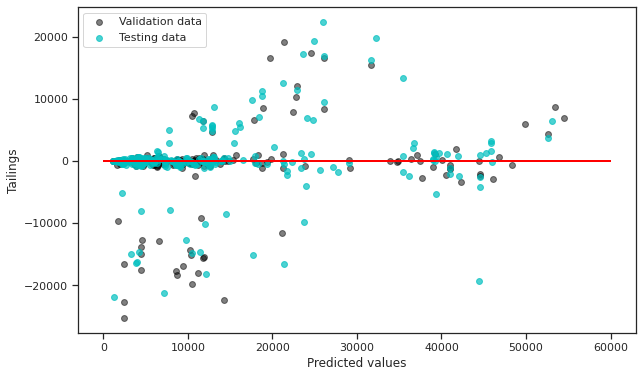

In [129]:
plt.figure(figsize=(10, 6))

y_true = forest_data[1][1]
y_pred = forest_data[1][2]
plt.scatter(y_pred, y_pred - y_true,
            c='black', marker='o', s=35, alpha=0.5,
            label='Validation data')

y_true = forest_data[2][1]
y_pred = forest_data[2][2]
plt.scatter(y_pred, y_pred - y_true,
            c='c', marker='o', s=35, alpha=0.7,
            label='Testing data')

plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=0, xmax=60000, lw=2, color='red')
plt.show()

The diagram above shows the predicted values on the x axis and the respective tailings (how much the prediction missed by compared to the actual value) on the y axis. It seems like the random forest model is relatively good at predicting when the targeted value is between 0 and 30000, except for a few outliars. In hindsight, these should perhaps be taken out of the dataset before training. Values predicted values above 30000 is less accurate, yet not too bad.

# 6. Predicting charges using a deep neural network model

The model below is the outcome of several experiments and iterations of itself. The first model had and MAE of 8600, while the final model's MAE is 1650.

In [130]:
def exponential_decay(lr0, s):
  """Set function for exponential decay learning rate scheduler"""
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 ** (epoch / s)
  return exponential_decay_fn

In [131]:
# Set TensorFlow seed
tf.random.set_seed(42)

# Define custom dense layer
DenseLayer = partial(
    tf.keras.layers.Dense,
    activation='elu', 
    kernel_initializer='he_normal',
    kernel_constraint=tf.keras.constraints.max_norm(1.)
)

# Initialize model
DNN_model = tf.keras.Sequential()

# Add n number of hidden dense layers
n_layers = 5
n_neurons = 300
for layer in range(n_layers):
  DNN_model.add(DenseLayer(n_neurons))
  DNN_model.add(tf.keras.layers.Dropout(rate=0.2))

# Add output layer
DNN_model.add(tf.keras.layers.Dense(1))

# Compile model
DNN_model.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae', 'mse']
)

# Define callbacks
cb = []
cb.append(tf.keras.callbacks.EarlyStopping(patience=25))
#cb.append(tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=5))  # performance lr scheduler
cb.append(tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.008, s=50)))

# Fit model
DNN_history = DNN_model.fit(
    x_train_norm, y_train,
    validation_data=(x_valid_norm, y_valid),
    callbacks=cb,
    epochs=1000,
    verbose=0)

# Evaluate model
valid_res = DNN_model.evaluate(x_valid_norm, y_valid)
test_res = DNN_model.evaluate(x_test_norm, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 1652.0642 - mae: 1652.0642 - mse: 19542814.0000


In [132]:
prediction_results = add_results(
    results_df=prediction_results,
    model_name='DNN_model',
    mae_valid=valid_res[1],
    mae_test=test_res[1],
    mse_valid=valid_res[2],
    mse_test=test_res[2]
)
prediction_results.round(2)

,model_variant,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.50,4811.50,41521736.0,41521736.00
1,random_forest_model,2827.67,2534.83,38553721.1,29772806.67
2,DNN_model,2261.60,1652.06,30841964.0,19542814.00


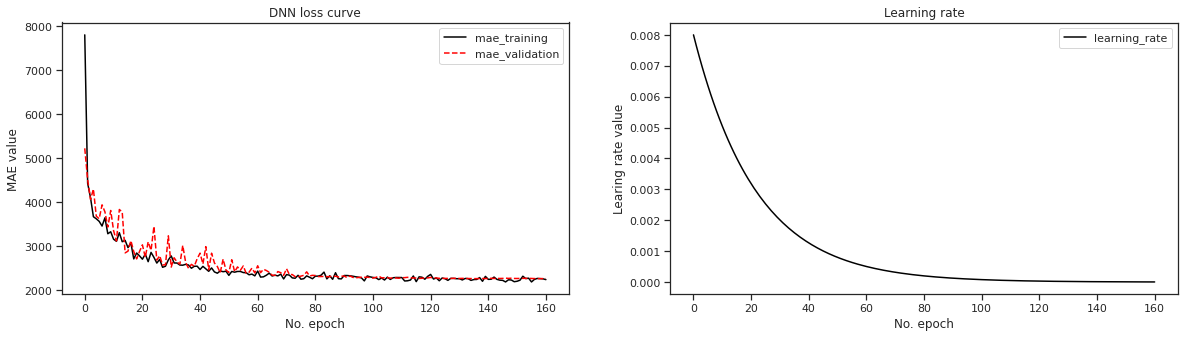

In [133]:
# Plot loss curve and learning rate

# Initialize plot
sns.set(palette='Set2', style='ticks')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.ticklabel_format(useOffset=False)

# Plot loss curve
ax1.plot(
    DNN_history.history['mae'], 
    label='mae_training',
    color='black')
ax1.plot(
    DNN_history.history['val_mae'],
    label='mae_validation',
    linestyle='dashed',
    color='red')
ax1.set_xlabel('No. epoch')
ax1.set_ylabel('MAE value')
ax1.set_title('DNN loss curve')
ax1.legend(loc='upper right')

# Plot learning rate
ax2.plot(
    DNN_history.history['lr'],
    label='learning_rate',
    color='black')
ax2.set_xlabel('No. epoch')
ax2.set_ylabel('Learing rate value')
ax2.set_title('Learning rate')
ax2.legend(loc='upper right')

plt.show()

The loss curve goes to show that there is no overfitting on the training data, which is largely thanks to the *dropout* method. The learning rate plot is just to confirm that the learning rate scheduler works as inteded.

# 7. Summary

In [134]:
prediction_results.round(2)

,model_variant,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.50,4811.50,41521736.0,41521736.00
1,random_forest_model,2827.67,2534.83,38553721.1,29772806.67
2,DNN_model,2261.60,1652.06,30841964.0,19542814.00


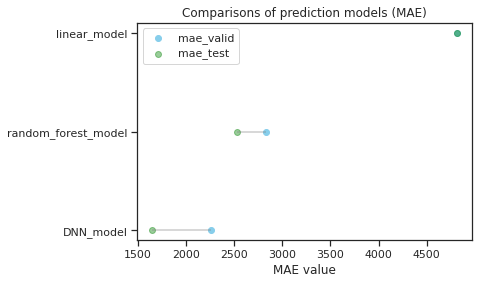

In [135]:
# Plot MAE comparison
df_ordered = prediction_results.sort_values(by='mae_valid')
my_range=range(1, len(prediction_results.index)+1)

plt.hlines(y=my_range, xmin=df_ordered['mae_valid'],
           xmax=df_ordered['mae_test'], color='grey',
           alpha=0.4)
plt.scatter(df_ordered['mae_valid'], my_range, color='skyblue',
            alpha=1, label='mae_valid')
plt.scatter(df_ordered['mae_test'], my_range, color='green',
            alpha=0.4, label='mae_test')

plt.yticks(my_range, df_ordered['model_variant'])
plt.title('Comparisons of prediction models (MAE)')
plt.xlabel('MAE value')
plt.legend()

plt.show()

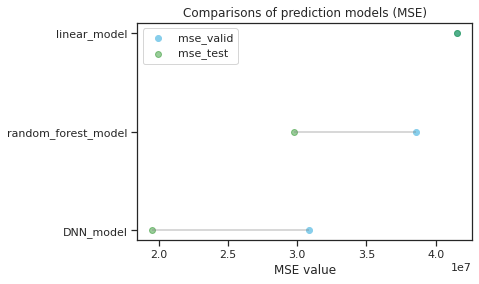

In [136]:
# Plot MSE comparison
df_ordered = prediction_results.sort_values(by='mse_valid')
my_range=range(1, len(prediction_results.index)+1)

plt.hlines(y=my_range, xmin=df_ordered['mse_valid'],
           xmax=df_ordered['mse_test'], color='grey',
           alpha=0.4)
plt.scatter(df_ordered['mse_valid'], my_range, color='skyblue',
            alpha=1, label='mse_valid')
plt.scatter(df_ordered['mse_test'], my_range, color='green',
            alpha=0.4, label='mse_test')

plt.yticks(my_range, df_ordered['model_variant'])
plt.title('Comparisons of prediction models (MSE)')
plt.xlabel('MSE value')
plt.legend()

plt.show()

Naturally, a the neural network performed better than the two other models. Firstly, the DNN model has significantly better MAE score, which means that its good at generalizing. Moreover, the DNN model has a good MSE score, which is a good metric for how good it performs at predicting people with high charges.